### Import Required Libraries

In [36]:
import glob
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import time
import json
# from torchvision.transforms import Rescale
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd

### Path to different splits of the data

In [2]:
train_dir='D:/og_dataset/glacier_data/splits/train/'
test_dir='D:/og_dataset/glacier_data/splits/test/'
dev_dir='D:/og_dataset/glacier_data/splits/train/'

### Getting Channels Mean and Std deviations 

In [5]:
norm_loc="D:/og_dataset/glacier_data/slices/stats_train.json"
channel_stats=json.load(open(norm_loc))

### Creating Custom Dataset Class

In [6]:
class Custom_glacier_dataset(Dataset):
    
    def __init__(self,folder_path,mode,transform,channel_stats):
        """
        Intialize the dataset
        
        input:folder_path:The path of the train/val/dev directory
        
        """
        self.img_files=glob.glob(os.path.join(folder_path,'*img*')) ##get all path to the image numpy arrays in the folder
        self.mask_files=glob.glob(os.path.join(folder_path,'*mask*')) ## get all the path to the  mask numpy array in the folder 
        self.mode=mode
        self.transform=transform
        self.stats=channel_stats
        
    def __getitem__(self, index):

        """ getitem method to retrieve a single instance of the dataset
        Args:
            index(int): Index identifier of the data instance
        Return:
            data(x) and corresponding label(y)
        """

        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = np.load(img_path) ##read the img data
        
        ##select channels
        if self.mode=='rgb':
            data=stand_image(impute(data),self.stats)[:,:,:3] ##taking care of NaN value ad normalising the image.
        elif self.mode =='ir':
            data=stand_image(impute(data),channel_stats)[:,:,5:8] ##taking care of NaN value ad normalising the image.
        elif self.mode =='index':
            data=stand_image(impute(data),channel_stats)[:,:,10:13] ##taking care of NaN value ad normalising the image.
        elif self.mode =='other':
            data=stand_image(impute(data),channel_stats)[:,:,[4,3,1]] ##taking care of NaN value ad normalising the image.
            
        if self.transform:
             data=self.transform(torch.from_numpy(data).float().permute(2,0,1)) ## Converting image into format (C,N,M)
        
        label = np.load(mask_path) ## read mask data
        
        ##creating labels from the mask
        
        if np.nansum(label[:,:,0])==0:     #> (0.2*label.shape[0]*label.shape[1]): ###App
            label=np.array([0])
        else:
            label=np.array([1])

        return data , torch.from_numpy(label).long()
    
    def __len__(self):
        """ Function to return the length of the dataset
            Args:
                None
            Return:
                len(img_files)(int): The length of the dataset (img_files)
        """
        return len(self.img_files)
        

### Dataloader for different splits of the dataset

In [7]:
def data_loader(transform,batch_size=32,train_folder='',test_folder='',dev_folder='',mode='rgb',stats=channel_stats):
    
    ### Getting Train and Val dataloader's required in fine-tuning stage of VGG-16 to pass dataset in batches.
    if train_folder:
        train_dataset=Custom_glacier_dataset(train_folder,mode,transform,channel_stats=stats)
        dev_dataset=Custom_glacier_dataset(dev_folder,mode,transform,channel_stats=stats)
        return {'train':DataLoader(train_dataset,batch_size=batch_size,num_workers=0,shuffle=False,pin_memory=True),'val':DataLoader(dev_dataset,batch_size=batch_size,num_workers=0,shuffle=True,pin_memory=True)}
    
    ### Getting Test Dataloader used in prediction stage
    elif test_folder:
        test_dataset=Custom_glacier_dataset(test_folder,mode,transform,channel_stats=stats)
        return DataLoader(test_dataset,batch_size=batch_size,num_workers=0,shuffle=False)
    
    

### Pre- Processing functions for the splits

In [8]:
def impute(img,replace=0):
    ##replace NaN values
    return np.nan_to_num(img,nan=replace)

In [9]:


def stand_image(img,channel_stats):
    
    ### Normalising the un-normalised images
    
    if np.nansum(img) %1 !=0: # to detect whether an image is normalized we compute the sum of all its elements.
        # If the sum is integer, then we consider it normalized
        img=(img-channel_stats['means'])/channel_stats['stds']
        
    return img
        

In [10]:
composed=transforms.Compose([transforms.Resize(224)]) ## Rescaling the image to 224,224 dimensions as required by VGG-16 network

###  Set Models Parameters gradient attribute to False

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    ## Freezing the network weights so that they don't change while fine tuning
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
def initialize_model_vgg16(num_classes, feature_extract, use_pretrained=True):
    
    ##Getting VGG-16 network 
    model_ft = models.vgg16(pretrained=use_pretrained)
    ## Setting gradient attribute to false(No training)
    set_parameter_requires_grad(model_ft, feature_extract)
    ##Changing the final layer of the VGG-16 to linear layer with just two nodes
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    ##Input image size
    input_size = 224

    

    return model_ft, input_size

feature_extract=True

# Initialize the model for this run
model_ft, input_size = initialize_model_vgg16(2, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Fine-tuning VGG-16:
> In this steps, the weights of newly modified layer are learned where all the previous layers weights are fixed

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    if __name__ == '__main__':
        since = time.time()
        ## Keep track of the validation set accucracy
        val_acc_history = []
        
        ## Store the loses per epoch for Val and train set
        val_loss=[]
        train_loss=[]
        
        ## Storing the best model weights
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            t_loss=0
            v_loss=0
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    labels=labels.reshape(-1)
  
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss

                        if  phase == 'train':

                            outputs= model(inputs)
#                             print(labels.size(),labels.reshape(-1).size())
                            loss = criterion(outputs, labels)
                            t_loss+=loss*inputs.size()[0]

                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            v_loss+=loss*inputs.size()[0]

                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                ## Storing epoch's loss for Training and Validation Set
                if phase=='train':
                    train_loss.append(t_loss)
                else:
                    val_loss.append(v_loss)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                # if the model prediction improves change the stored Validation accuracy(best) and model weights(best) 
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val':
                    val_acc_history.append(epoch_acc)

    

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, val_acc_history,train_loss,val_loss

###  Getting prediction on Test Dataset from Fine-Tune model

In [14]:
def test_model(model, dataloaders):
    test_corr=0
    tp=0
    fp=0
    fn=0
    
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels=labels.reshape(-1)

        ## Prediction of test dataset batch wise
        
        output=model(inputs)
        _,label_pred=torch.max(output,1)
        
        ##Checking accuracy for batch
#         print(labels,label_pred)
        test_corr+=torch.sum(label_pred==labels.data)
        tp+=torch.sum((label_pred==1) & (labels.data==1))
        fp+=torch.sum((label_pred==1) & (labels.data==0))
        fn+=torch.sum((label_pred==0) & (labels.data==1))
        
    ## Accuracy    
    test_accuracy=test_corr/len(dataloaders.dataset)
    test_accuracy=test_accuracy.cpu().detach().numpy()
    ##Precision
    Precision=tp/(fp+tp)
    Precision=Precision.cpu().detach().numpy()
    ##Recal
    Recall=tp/(fn+tp)
    Recall=Recall.cpu().detach().numpy()
    return test_accuracy,Precision,Recall
        
        
        

In [15]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Loss function

In [16]:
criterion = nn.CrossEntropyLoss()
results=[]

### Fine-Tuning Model-1

> Based on RGB bands of the images.

In [17]:
## Getting Train and Val dataset
dataloader_dict=data_loader(composed,train_folder=train_dir,dev_folder=dev_dir,batch_size=32,stats=channel_stats)

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [18]:
### rgb
model_1, val_acc_history_1,train_loss_1,val_loss_1=train_model(model_ft, dataloader_dict, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3949 Acc: 0.7755
val Loss: 0.1186 Acc: 0.8864

Epoch 1/9
----------
train Loss: 0.0544 Acc: 0.9739
val Loss: 0.0118 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.0144 Acc: 1.0000
val Loss: 0.0077 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0125 Acc: 0.9987
val Loss: 0.0064 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0087 Acc: 1.0000
val Loss: 0.0054 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0085 Acc: 1.0000
val Loss: 0.0046 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0069 Acc: 1.0000
val Loss: 0.0041 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0059 Acc: 1.0000
val Loss: 0.0037 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0061 Acc: 1.0000
val Loss: 0.0034 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0057 Acc: 1.0000
val Loss: 0.0030 Acc: 1.0000

Training complete in 65m 34s
Best val Acc: 1.000000


In [27]:
##Read Test dataset
dataloader_test=data_loader(composed,test_folder=test_dir,batch_size=32,stats=channel_stats,mode='rgb')
##Get prediction statistics 
test_accuracy_1,Precision_1,Recall_1=test_model(model_1, dataloader_test)
## Store them
results.append([round(float(test_accuracy_1),3),round(float(Precision_1),3),round(float(Recall_1),3)])

results[0]

1.0 1.0 1.0


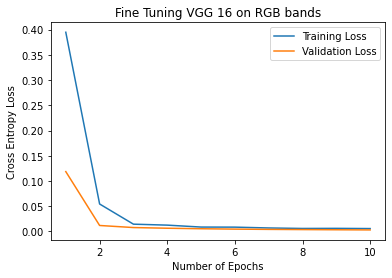

In [38]:

train_dev=data_loader(composed,train_folder=train_dir,dev_folder=dev_dir,batch_size=32,stats=channel_stats,mode='rgb')

train_size=len(train_dev['train'].dataset)
dev_size=len(train_dev['val'].dataset)

fig=sns.lineplot(y=[float(train_loss_1[2*i].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Training Loss')
sns.lineplot(y=[float(val_loss_1[2*i+1].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Validation Loss')
fig.set(ylabel='Cross Entropy Loss',xlabel='Number of Epochs',title='Fine Tuning VGG 16 on RGB bands')
fig.legend()


### Fine-Tuning Model-2

> Based on Infrared bands of the images.

In [20]:
## Getting Train and Val dataset
dataloader_dict=data_loader(composed,train_folder=train_dir,dev_folder=dev_dir,batch_size=32,stats=channel_stats,mode='ir')

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [21]:
### rgb
model_2, val_acc_history_2,train_loss_2,val_loss_2=train_model(model_ft, dataloader_dict, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0949 Acc: 0.9661
val Loss: 0.0127 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.0179 Acc: 0.9987
val Loss: 0.0038 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.0023 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.0018 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.0014 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.0012 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.0011 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.0010 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.0009 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.0008 Acc: 1.0000

Training complete in 62m 40s
Best val Acc: 1.000000


In [28]:
## Read the test dataset
dataloader_test=data_loader(composed,test_folder=test_dir,batch_size=32,stats=channel_stats,mode='ir')
## Getting prediction statistics
test_accuracy_2,Precision_2,Recall_2=test_model(model_2, dataloader_test)
##Store them
results.append([round(float(test_accuracy_2),3),round(float(Precision_2),3),round(float(Recall_2),3)])
results[1]

[0.991, 1.0, 0.982]

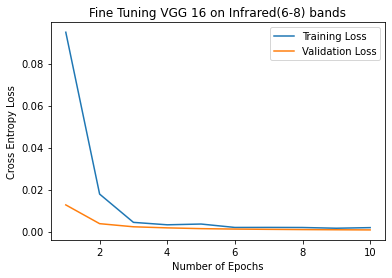

In [39]:
##Plotting the loss curves
fig=sns.lineplot(y=[float(train_loss_2[2*i].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Training Loss')
sns.lineplot(y=[float(val_loss_2[2*i+1].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Validation Loss')
fig.set(ylabel='Cross Entropy Loss',xlabel='Number of Epochs',title='Fine Tuning VGG 16 on Infrared(6-8) bands')
fig.legend()


### Fine-Tuning Model-3

> Based on Index bands(11-13) of the images.

In [22]:
## Getting Train and Val dataset
dataloader_dict=data_loader(composed,train_folder=train_dir,dev_folder=dev_dir,batch_size=32,stats=channel_stats,mode='index')

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [23]:
### rgb
model_3, val_acc_history_3,train_loss_3,val_loss_3=train_model(model_ft, dataloader_dict, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5871 Acc: 0.8146
val Loss: 0.0257 Acc: 0.9922

Epoch 1/9
----------
train Loss: 0.0521 Acc: 0.9883
val Loss: 0.0195 Acc: 0.9909

Epoch 2/9
----------
train Loss: 0.0248 Acc: 0.9883
val Loss: 0.0135 Acc: 0.9948

Epoch 3/9
----------
train Loss: 0.0143 Acc: 0.9961
val Loss: 0.0117 Acc: 0.9948

Epoch 4/9
----------
train Loss: 0.0208 Acc: 0.9922
val Loss: 0.0100 Acc: 0.9961

Epoch 5/9
----------
train Loss: 0.0144 Acc: 0.9961
val Loss: 0.0087 Acc: 0.9961

Epoch 6/9
----------
train Loss: 0.0147 Acc: 0.9948
val Loss: 0.0082 Acc: 0.9987

Epoch 7/9
----------
train Loss: 0.0131 Acc: 0.9948
val Loss: 0.0070 Acc: 0.9974

Epoch 8/9
----------
train Loss: 0.0106 Acc: 0.9974
val Loss: 0.0064 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0079 Acc: 0.9987
val Loss: 0.0059 Acc: 1.0000

Training complete in 62m 13s
Best val Acc: 1.000000


In [29]:
## Read the test dataset
dataloader_test=data_loader(composed,test_folder=test_dir,batch_size=32,stats=channel_stats,mode='index')
## get prediction performance
test_accuracy_3,Precision_3,Recall_3=test_model(model_3, dataloader_test)
##Store them
results.append([round(float(test_accuracy_3),3),round(float(Precision_3),3),round(float(Recall_3),3)])
results[2]

[0.85, 0.867, 0.827]

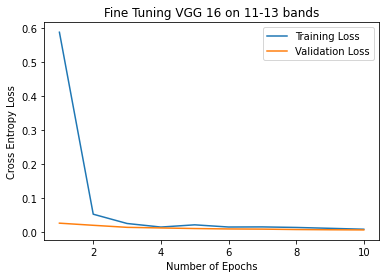

In [40]:
## Plotting the loss curves

fig=sns.lineplot(y=[float(train_loss_3[2*i].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Training Loss')
sns.lineplot(y=[float(val_loss_3[2*i+1].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Validation Loss')
fig.set(ylabel='Cross Entropy Loss',xlabel='Number of Epochs',title='Fine Tuning VGG 16 on 11-13 bands')
fig.legend()


### Fine-Tuning Model-4

> Based on 5-4-2 bands of the images.

In [24]:
## Getting Train and Val dataset
dataloader_dict=data_loader(composed,train_folder=train_dir,dev_folder=dev_dir,batch_size=32,stats=channel_stats,mode='other')

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [25]:
### 5-4-2 bands
model_4, val_acc_history_4,train_loss_4,val_loss_4=train_model(model_ft, dataloader_dict, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9580 Acc: 0.8655
val Loss: 0.0732 Acc: 0.9843

Epoch 1/9
----------
train Loss: 0.0759 Acc: 0.9752
val Loss: 0.0301 Acc: 0.9974

Epoch 2/9
----------
train Loss: 0.0343 Acc: 0.9922
val Loss: 0.0100 Acc: 0.9987

Epoch 3/9
----------
train Loss: 0.0182 Acc: 0.9974
val Loss: 0.0063 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0123 Acc: 0.9987
val Loss: 0.0047 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0097 Acc: 1.0000
val Loss: 0.0040 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0084 Acc: 1.0000
val Loss: 0.0034 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0075 Acc: 1.0000
val Loss: 0.0029 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0056 Acc: 1.0000
val Loss: 0.0027 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0062 Acc: 1.0000
val Loss: 0.0025 Acc: 1.0000

Training complete in 63m 25s
Best val Acc: 1.000000


In [32]:
## Reading the test dataset
dataloader_test=data_loader(composed,test_folder=test_dir,batch_size=32,stats=channel_stats,mode='other')
## Getting the prediction performance
test_accuracy_4,Precision_4,Recall_4=test_model(model_4, dataloader_test)
## store them
results.append([round(float(test_accuracy_4),4),round(float(Precision_4),4),round(float(Recall_4),4)])
results[3]

[1.0, 1.0, 1.0]

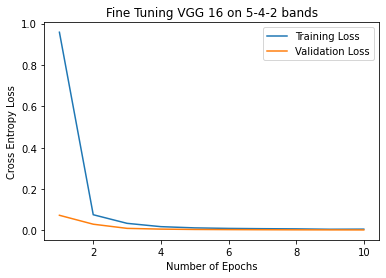

In [41]:
## PLotting the loss curves

fig=sns.lineplot(y=[float(train_loss_4[2*i].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Training Loss')
sns.lineplot(y=[float(val_loss_4[2*i+1].cpu().detach())/train_size for i in range(10)],x=np.arange(1,11),label='Validation Loss')
fig.set(ylabel='Cross Entropy Loss',xlabel='Number of Epochs',title='Fine Tuning VGG 16 on 5-4-2 bands')
fig.legend()


In [33]:
order=[1,0,3,2]
results_update=[results[i] for i in order]
df=pd.DataFrame(np.array(results_update).T,index=['Accuracy','Precision','Recall'])
df.columns=['6-8','RGB','5-4-2','11-12-13']
df.index.name='Metrics'
df

,6-8,RGB,5-4-2,11-12-13
Metrics,,,,
Accuracy,0.991,1.0,1.0,0.850
Precision,1.000,1.0,1.0,0.867
Recall,0.982,1.0,1.0,0.827


In [ ]:
# df.to_csv('CNN_metrics.csv')

In [34]:
train_loss_1

[tensor(302.4689, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(302.4689, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(41.7027, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(41.7027, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(11.0558, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(11.0558, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(9.5977, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(9.5977, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(6.6617, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(6.6617, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(6.5471, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(6.5471, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(5.2947, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(5.2947, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(4.5424, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(4.5424, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(4.6930, device='cuda:0', grad_fn=<AddBackward0>),
 tenso